# Data Science for Business

## Spring 2020, module 4 @ HSE

---

## Home assignment 4


Author: **Miron Rogovets**

---

_"For this task your main goal is to decrease company losses due to customer’s churn. We will compare two discount strategies: providing a 20% discount with a 75% acceptance rate and a 30% discount with a 90% acceptance rate."_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('data/telecom_data.csv')
df.head(3)

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24-48
1,2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0-12
2,3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24-48


In [4]:
data = df.drop(columns=['index', 'tenure_group'])

### I. Data preprocessing (5).

This time we will skip all the exploration steps and only do some simple features preprocessing:

1. Generate `tenure_group` attribute: discretize `tenure` into 6 groups: “0-12”, “12-24”, “24-36”, “36-48”, “48-60”, “60+” (all are left closed intervals). What are the sizes of these groups?

_Tenure refers to the number of months that a customer has subscribed for. Do not drop the `tenure` column._


In [5]:
data['tenure_group'] = 0
data.loc[(data.tenure >= 12) & (data.tenure < 24), 'tenure_group'] = 1
data.loc[(data.tenure >= 24) & (data.tenure < 36), 'tenure_group'] = 2
data.loc[(data.tenure >= 36) & (data.tenure < 48), 'tenure_group'] = 3
data.loc[(data.tenure >= 48) & (data.tenure < 60), 'tenure_group'] = 4
data.loc[data.tenure >= 60, 'tenure_group'] = 5

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
1,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
2,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3


In [6]:
data['tenure_group'].value_counts().sort_index()

0    1573
1     844
2     719
3     670
4     775
5    1462
Name: tenure_group, dtype: int64

2. Preprocess categorical columns with only 2 unique values (“binary” columns): replace one unique value with 0 and another with 1 (label encoding). How many __such__ columns do you have?

_E.g. for the `gender` attribute you may replace Female with 1 and Male with 0 or vice versa._


In [7]:
cats = data.dtypes[data.dtypes == 'object'].index.drop('customerID').values
binary = [c for c in cats if len(data[c].unique()) == 2]
nonbinary = [c for c in cats if len(data[c].unique()) != 2]

f"Binary columns count: {len(binary)}"

'Binary columns count: 13'

In [8]:
le = LabelEncoder()

for col in binary:
    data[col] = le.fit_transform(data[col])

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,5575-GNVDE,1,0,0,0,34,1,No,DSL,1,...,0,0,0,One year,0,Mailed check,56.95,1889.50,0,2
1,3668-QPYBK,1,0,0,0,2,1,No,DSL,1,...,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,0
2,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,1,...,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,3


3. Preprocess categorical columns with more then 2 unique values using dummy encoding (=one-hot encoding). How many __such__ columns (before dummy encoding) do you have? 


In [9]:
f"Nonbinary columns count: {len(nonbinary)}"

'Nonbinary columns count: 4'

In [10]:
data = pd.get_dummies(data, prefix=nonbinary, columns=nonbinary, drop_first=True)
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,...,tenure_group,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,5575-GNVDE,1,0,0,0,34,1,1,0,1,...,2,0,0,0,0,1,0,0,0,1
1,3668-QPYBK,1,0,0,0,2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,7795-CFOCW,1,0,0,0,45,0,1,0,1,...,3,1,0,0,0,1,0,0,0,0


4. Drop customerID attribute.

In [11]:
data.drop(columns=['customerID'], inplace=True)

### II. Build a churn model (5).

1. Build 2 classification models to predict customers churn:
   - Logistic Regression. What is the ROC AUC of this model?
   - Random Forest. What is the ROC AUC of this model?


In [12]:
y = data.Churn
X = data.drop(columns=['Churn'])

In [13]:
logit = LogisticRegression(max_iter=1000)
forest = RandomForestClassifier()

In [119]:
f"{cross_val_score(logit, X, y, scoring=('roc_auc')).mean():.2f}"

'0.93'

In [120]:
f"{cross_val_score(forest, X, y, scoring=('roc_auc')).mean():.2f}"

'0.92'

In [16]:
lpred = cross_val_predict(logit, X, y)
f"{roc_auc_score(y, lpred):.2f}"

'0.85'

In [17]:
rpred = cross_val_predict(forest, X, y)
f"{roc_auc_score(y, rpred):.2f}"

'0.84'

### III. Compare two discount strategies (25 + 10).

**Assumptions:**
- Every customer pays the same price p which is the average of `MonthlyCharges`.
- If we decide to provide a discount we provide it to all the customers who are predicted as Churn=Yes.
- When we compute gains, costs and losses we compute them for the short term.
- Strategy’s profit is the difference between gains, costs and losses: `profit = gains - costs - losses`
- Profit per customer is the total profit divided by the number of customers (if the person churns the person is not a customer anymore).

**Strategy A:** Provide a 20% discount with a 75% acceptance rate.

**Strategy B:** Provide a 30% discount with a 90% acceptance rate.



In [18]:
p = data['MonthlyCharges'].mean()
f"{p:.2f}"

'62.86'

#### 1. Use the default threshold of 0.5 to compute the confusion matrix. Based on this confusion matrix report (5 points):
- TP, FP, TN, FN
- Losses if you do not apply any discount strategy.
- Total **gains** from the discount strategy B.
- Total **costs** of the discount strategy B.
- Total **losses** of the discount strategy B.
- Total profit of the discount strategy B.
- Profit per customer $p_d$ (using strategy B). 

#### 2. Use 9 different thresholds: 0.1, 0.2, … 0.9. Answer to the following questions (10 points):
- What is the threshold with the highest accuracy, using strategy B?
- What is the threshold with the highest profit, using strategy B? What is the highest profit, using strategy B?
- What is the threshold with the highest profit per customer, using strategy B ?  What is the highest profit per customer, using strategy B?
- What is the ratio of profit per customer (obtained on the previous step) and p? $\frac{p_d}{p}$
- Which strategy yields the highest profit (A or B)? What are the TP, FP, TN, FN in this case? What is the highest profit in that case?
- Which strategy yields the highest profit per customer (A or B)? What are the TP, FP, TN, FN in this case? What is the highest profit per customer in that case?


In [63]:
def plot_cm(cm, labels=['Not Churn', 'Churn']):
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cm, columns=labels, index=labels), annot=True, cmap="Blues", fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix', y = 1.1)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [165]:
def compute_metrics(cm, p, acceptance, discount, plot=False):
    if plot:
        plot_cm(cm)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    gains = tp * acceptance * p
    costs = (tp + fp) * discount * p
    losses = fn * p + tp * (1 - acceptance) * (1 - discount) * p
    profit = gains - costs - losses
    profit2 = tp * acceptance * (1 - discount) * p + fp * (1 - discount) * p  + tn * p 
    per_customer = profit / (tn + tp * acceptance + fp)
    per_customer2 = profit2 / (tn + tp * acceptance + fp)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Gains: {gains:.2f}")
    print(f"Costs: {costs:.2f}")
    print(f"Losses: {losses:.2f}")
    print(f"Profit: {profit:.2f}")
    print(f"Profit2: {profit2:.2f}")
    print(f"Profit per customer: {per_customer:.2f}")
    print(f"Profit per customer2: {per_customer2:.2f}")
    return accuracy, profit, per_customer

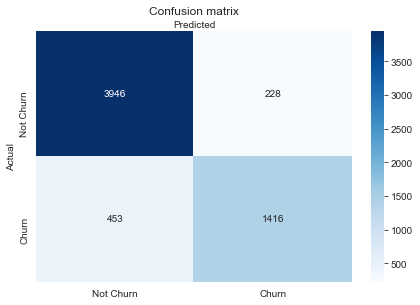

array([[3946,  228],
       [ 453, 1416]])

In [64]:
cm = confusion_matrix(y, lpred)
plot_cm(cm)
cm

In [160]:
tn, fp, fn, tp = cm.ravel()
print(f"TP={tp}   FP={fp}   TN={tn}   FN={fn}")

TP=1416   FP=228   TN=3946   FN=453


In [161]:
f"Losses if we do not apply any strategy: {(tp + fn) * p:.2f}"

'Losses if we do not apply any strategy: 117481.16'

In [162]:
thresh = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [163]:
A = {'acceptance':0.75, 'discount': 0.2}
B = {'acceptance':0.9, 'discount': 0.3}

In [166]:
acc, pr, pp = compute_metrics(cm, p, B['acceptance'], B['discount'])
acc, pr, pp

Accuracy: 0.89
Gains: 80105.93
Costs: 31001.45
Losses: 34705.03
Profit: 14399.46
Profit2: 314142.98
Profit per customer: 2.64
Profit per customer2: 57.66


(0.887307628661261, 14399.455900380613, 2.6428778908267776)

In [150]:
f"{pp / p:.2f}"

'0.04'

In [138]:
max_acc = 0.0
max_prof = 0.0
max_pp = 0.0

acc_t = 0.0
prof_t = 0.0
pp_t = 0.0

for t in thresh:
    probas = cross_val_predict(logit, X, y, method='predict_proba')
    pred = (probas[:,1] >= t).astype(int)
    matrix = confusion_matrix(y, pred)
    print(f'----------------------Treshold = {t}-----------------------------')
    acc, prof, pp = compute_metrics(matrix, p, B['acceptance'], B['discount'])
    if acc > max_acc:
        max_acc = acc
        acc_t = t
    if prof > max_prof:
        max_prof = prof
        prof_t = t
    if pp > max_pp:
        max_pp = pp
        pp_t = t
    print('-------------------------------------------------------------------')

----------------------Treshold = 0.1-----------------------------
Accuracy: 0.73
Gains: 99057.55
Costs: 61776.61
Losses: 15121.69
Profit: 22159.25
Profit per customer: 3.85
-------------------------------------------------------------------
----------------------Treshold = 0.2-----------------------------
Accuracy: 0.80
Gains: 93626.64
Costs: 50160.49
Losses: 20733.63
Profit: 22732.51
Profit per customer: 4.01
-------------------------------------------------------------------
----------------------Treshold = 0.3-----------------------------
Accuracy: 0.84
Gains: 88874.59
Costs: 42051.84
Losses: 25644.08
Profit: 21178.67
Profit per customer: 3.79
-------------------------------------------------------------------
----------------------Treshold = 0.4-----------------------------
Accuracy: 0.87
Gains: 84461.97
Costs: 35791.21
Losses: 30203.78
Profit: 18466.98
Profit per customer: 3.35
-------------------------------------------------------------------
----------------------Treshold = 0.5

In [139]:
print(f"Highest accuracy threshold: {acc_t}")
print(f"Highest profit threshold: {prof_t} ; Highest profit {max_prof:.2f}")
print(f"Highest prof/cust threshold: {pp_t} ; Highest prof/cust {max_pp:.2f}")

Highest accuracy threshold: 0.6
Highest profit threshold: 0.2 ; Highest profit 22732.51
Highest prof/cust threshold: 0.2 ; Highest prof/cust 4.01


In [140]:
B_res = {'prof': max_prof, 'pp': max_pp}

In [141]:
max_acc = 0.0
max_prof = 0.0
max_pp = 0.0

acc_t = 0.0
prof_t = 0.0
pp_t = 0.0

for t in thresh:
    probas = cross_val_predict(logit, X, y, method='predict_proba')
    pred = (probas[:,1] >= t).astype(int)
    matrix = confusion_matrix(y, pred)
    print(f'----------------------Treshold = {t}-----------------------------')
    acc, prof, pp = compute_metrics(matrix, p, A['acceptance'], A['discount'])
    if acc > max_acc:
        max_acc = acc
        acc_t = t
    if prof > max_prof:
        max_prof = prof
        prof_t = t
    if pp > max_pp:
        max_pp = pp
        pp_t = t
    print('-------------------------------------------------------------------')

----------------------Treshold = 0.1-----------------------------
Accuracy: 0.73
Gains: 82547.95
Costs: 41184.41
Losses: 29430.00
Profit: 11933.55
Profit per customer: 2.17
-------------------------------------------------------------------
----------------------Treshold = 0.2-----------------------------
Accuracy: 0.80
Gains: 78022.20
Costs: 33440.33
Losses: 34257.48
Profit: 10324.39
Profit per customer: 1.91
-------------------------------------------------------------------
----------------------Treshold = 0.3-----------------------------
Accuracy: 0.84
Gains: 74062.16
Costs: 28034.56
Losses: 38481.52
Profit: 7546.07
Profit per customer: 1.41
-------------------------------------------------------------------
----------------------Treshold = 0.4-----------------------------
Accuracy: 0.87
Gains: 70384.98
Costs: 23860.81
Losses: 42403.85
Profit: 4120.33
Profit per customer: 0.78
-------------------------------------------------------------------
----------------------Treshold = 0.5--

In [142]:
print(f"Highest accuracy threshold: {acc_t}")
print(f"Highest profit threshold: {prof_t} ; Highest profit {max_prof:.2f}")
print(f"Highest prof/cust threshold: {pp_t} ; Highest prof/cust {max_pp:.2f}")

Highest accuracy threshold: 0.6
Highest profit threshold: 0.1 ; Highest profit 11933.55
Highest prof/cust threshold: 0.1 ; Highest prof/cust 2.17


In [143]:
A_res = {'prof': max_prof, 'pp': max_pp}

In [144]:
A_res

{'prof': 11933.545934552378, 'pp': 2.174777153319491}

In [145]:
B_res

{'prof': 22732.50928222737, 'pp': 4.01386232581043}

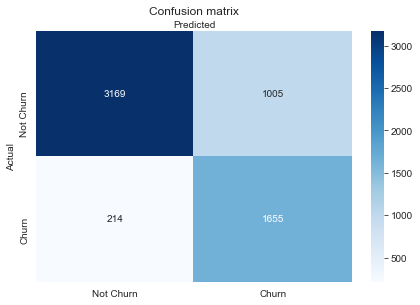

TP=1655   FP=1005   TN=3169   FN=214


In [147]:
probas = cross_val_predict(logit, X, y, method='predict_proba')
pred = (probas[:,1] >= 0.2).astype(int)
matrix = confusion_matrix(y, pred)
plot_cm(matrix)
tn, fp, fn, tp = matrix.ravel()
print(f"TP={tp}   FP={fp}   TN={tn}   FN={fn}")

In [153]:
(fp + tn) * p

262368.29460532847

In [154]:
tp * B['acceptance'] * (1-B['discount']) * p + fp * (1-B['discount']) * p  + tn * p 

314142.9752235644

In [169]:
ra=[]
for t in thresh:
    probas = cross_val_predict(logit, X, y, method='predict_proba')
    pred = (probas[:,1] >= t).astype(int)
    ra.append(roc_auc_score(y, pred))

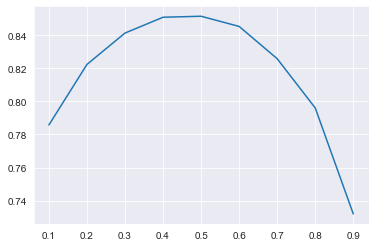

In [171]:
plt.plot(thresh, ra)

In [172]:
TN = []
FP = []
FN = []
TP = []

for t in thresh:
    probas = cross_val_predict(logit, X, y, method='predict_proba')
    pred = (probas[:,1] >= t).astype(int)
    matrix = confusion_matrix(y, pred)
    tn, fp, fn, tp = matrix.ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

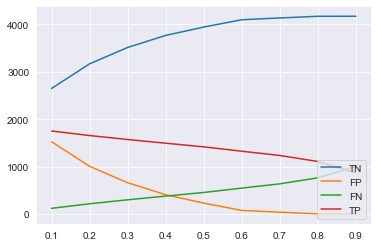

In [176]:
fig = plt.figure()
plt.plot(thresh, TN, label='TN')
plt.plot(thresh, FP, label='FP')
plt.plot(thresh, FN, label='FN')
plt.plot(thresh, TP, label='TP')
plt.legend(loc='lower right')
plt.show()